# Homework 2 - Data from the Web
## Extracting & Analyzing TopUniversities and TimesHigherEducation Data

## Library
* required libraries for this homework 

In [37]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn
import unicodedata
import re
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display
%matplotlib inline

### Preliminary of Data Scraping
Using postman interceptor, we figure out that universities data for corresponding sites can be found on link below:

top universities (QS):
<br>https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt

times higher education:
<br><a href="https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json">link</a>


### Variables
As we want to obtain the universities data from two main platforms that maintain global universities ranking, namely QS World University Rankings and Times World University ranking, we define prefix to indicate variables in the rest of this document as follow:
<br>

<h3>Top Universities = "qs"</h3>
<h3>Times Higher Education = "times"</h3>

### Assignment of Static Variables
We use pickle to store dataframes into files in order to avoid generating unnecessary traffic for every time executing this notebook.

In [6]:
# we store each main site url and its data url to web_urls
web_urls = [{'page':'https://www.topuniversities.com',
             'data':'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'},
            {'page':'https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats',
             'data':'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'}]

#reading from pickle, avoid generating too many web traffic
qs_top200    = pd.read_pickle("qs_top200_pickle")
times_top200 = pd.read_pickle("times_top200_pickle")


### Functions
We define 5 functions for later usage within this notebook:
1. function get_number_elements : Is used to get the value inside the HTML div element with specific class="number".
2. function crawl_topuniversities : Is used to obtain data from topuniversities and stores the result in panda Dataframe.
3. function crawl_timeshighereducation : Is used to obtain data from timeshighereducation and stores the result in panda Dataframe.
4. function convert_string: Is used to modify a string by removing parentheses (with its content inside) and converting non-ascii characters to ascii characters.
5. function df_convert_index : Is used to create a panda Dataframe with modified university_name (removal of parentheses and non-ascii) as its index.

In [7]:
def get_number_elements(htmlPage, className):
    """Function to return integer ELEMENT in <div class="number">ELEMENT</div>.
    Args:
        htmlPage  (BeautifulSoup obj) : HTML DOM to inspect for html <div> with class="number"
        className (string)            : parent class of html <div> with class="number" 
    Returns:
        number    (int) : Exact value of element inside <div> with class="number".
    """
    
    # Handle the exception if <div> class="number" cannot be found, setting default to zero
    try:
        number = int(((htmlPage.find('div', class_=className)).find('div', class_="number").text).replace(',',''))    
    except AttributeError:
        number = 0
    return number


def crawl_topuniversities(url, n_top):
    """
    Function to get universities data from topuniversities.com and to store it as panda dataframe.
    Gather the information of per university rank, name, country, region, total faculty members, total international faculty members,
    total students, and total international students.
    Args:
        url    (dict) : Dictionary obj contains main page URL with its corresponding data URL.
        n_top  (int)  : The number of desired N first top universities data, e.g. n_top=10 means the first top 10 universities. 
    Returns:
        universities (panda Dataframe) : Data of n_top universities from topuniversities.
    """
    
    # perform the HTTP request to data URL of the site and store the result to http_response
    http_response     = requests.get(url['data'])
    
    # render the result in json format and access "data" entry, pick only first n_top elements
    universities      = http_response.json()['data'][:n_top]
    
    # A list to form final dataframe
    list_universities = []
    
    # Iterate through the universities data
    for idx, university in enumerate(universities):
        
        # get the region, location, and overall_rank
        university_region      = university['region']
        university_country     = university['location']
        university_rank        = (int)(university['overall_rank'])
        
        # get HTML <a href> element by parsing HTML with BeautifulSoup
        university_info_html   = BeautifulSoup(university['uni'], 'html.parser')
        link_element           = university_info_html.find('a')
        
        # get the university name and link from <a href> element
        university_name        = link_element.text
        university_link        = link_element.get('href')

        # proceed a request to get detailed information of an university in its details page
        university_detail      = requests.get(url['page']+university_link)
        university_detail_html = BeautifulSoup(university_detail.text, 'html.parser')
        
        # Get the value inside <div class="number"> correspond to the given parent class
        n_f_members            = get_number_elements(university_detail_html,"total faculty")    
        n_inter_f_members      = get_number_elements(university_detail_html,"inter faculty") 
        n_students             = get_number_elements(university_detail_html,"total student") 
        n_inter_students       = get_number_elements(university_detail_html,"total inter") 
        
        # form a dictionary containing the desired information per university
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'region': university_region,
                                'total_faculty_members': n_f_members,
                                'total_international_faculty_members': n_inter_f_members,
                                'total_students': n_students,
                                'total_international_students': n_inter_students
                          })
        
        # store the dictionary into a list
        list_universities.append(university_data)
    
    # form the dataframe from a list of dictionaries
    universities = pd.DataFrame.from_dict(list_universities)
    
    return universities


def crawl_timeshighereducation(url, n_top):
    """
    Function to get universities data from timeshighereducation.com and to store it as panda dataframe.
    Gather the information of per university rank, name, country, ratio of student per staff, ratio of international students,
    and total students
    Args:
        url    (dict) : Dictionary obj contains main page URL with its corresponding data URL.
        n_top  (int)  : The number of desired N first top universities data, e.g. n_top=10 means the first top 10 universities. 
    Returns:
        universities (panda Dataframe) : Data of n_top universities from timeshighereducation.
    """
    
    # perform the HTTP request to data URL of the site and store the result to http_response
    http_response     = requests.get(url['data'])
    
    # render the result in json format and access "data" entry, pick only first n_top elements
    universities      = http_response.json()['data'][:n_top]
    
    # A list to form final dataframe
    list_universities = []
    
    # Iterate through the universities data
    for university in universities:
        
        # get and store the university rank, name, country, number of students, ratio of student per staff, ratio of international student 
        university_rank          = (int)(university['rank'].replace('=',''))
        university_name          = university['name']
        university_country       = university['location']
        n_students               = int(university['stats_number_students'].replace(',',''))
        student_staff_ratio      = float(university['stats_student_staff_ratio'])
        inter_student_percentage = float(university['stats_pc_intl_students'].strip('%'))/100 
        
        # form a dictionary containing the desired information per university
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'student_staff_ratio': student_staff_ratio,
                                'percentage_international_students': inter_student_percentage,
                                'total_students': n_students
                          })
        
        # store the dictionary into a list
        list_universities.append(university_data)
    
    # form the dataframe from a list of dictionaries
    universities = pd.DataFrame.from_dict(list_universities)
    
    return universities   

def convert_string(string):
    """
    Function to remove parentheses and non-ascii characters from a string.
    Args:
        string (string) : initial string.
    Returns:
        string_without_parentheses (string) : Converted string.
    """
    
    # using unicode to encode all characters in string into ascii
    str_byte                   = unicodedata.normalize("NFKD",string).encode('ascii','ignore')
    string_ascii               = str_byte.decode("utf-8", "strict")
    
    # remove parentheses and its content within a string
    string_without_parentheses = (re.sub(r'\([^)]*\)', '', string_ascii)).strip()
    
    return string_without_parentheses


def df_convert_index(df):
    """
    Function to index dataframe based on university name.
    University names will be converted beforehands to remove any parentheses and non-ascii characters.
    Args:
        df      (panda dataframe) : Original dataframe that we want to index.
    Returns:
        new_df  (panda Dataframe) : Indexed dataframe.
    """
    
    # create a panda series of indexes from converted university_name column in dataframe.
    new_index                 = pd.Series(list(map(convert_string, df['university_name'])))
    
    # form a new dataframe from original df, without university_name column.
    new_df                    = df.drop(['university_name'],axis=1)
    
    # set converted university_name as the index of the new dataframe 
    new_df['university_name'] = new_index
    new_df                    = new_df.set_index(['university_name'])
    
    return new_df

# Main Homework

## 1.Analysis of Top Universities Data
Now let's begin to do data scarping from topuniversities.com.<br>
<b> Please skip this part if you want to avoid generating web traffics. </b><br>
<b> Note that you will get the same data as from saved pickle file </b>

In [8]:
# Store the data of 200 top-ranking universities in topuniversities into a dataframe
qs_top200 = crawl_topuniversities(web_urls[0],200)

In [9]:
qs_top200.head(3)

,country,rank,region,total_faculty_members,total_international_faculty_members,total_international_students,total_students,university_name
0,United States,1,North America,2982,1679,3717,11067,Massachusetts Institute of Technology (MIT)
1,United States,2,North America,4285,2042,3611,15878,Stanford University
2,United States,3,North America,4350,1311,5266,22429,Harvard University


<b>Writing Data into a file</b>
<br><b>Note: Run this cell to save the qs_top200 dataframe into pickle file. Later, we can read the pickle file to avoid generating redundant HTTP requests</b>
<br><b>Please skip this part if you do not want to store the dataframe into a pickle file</b>

In [10]:
qs_top200.to_pickle("qs_top200_pickle")

### 1a. Best Universities: Ratio Faculty Members / Students

In [11]:
# find out which universities are the best in terms of ratio faculty member/student
f_members_students_r                                 = pd.DataFrame(qs_top200.university_name)
f_members_students_r["faculty_member_student_ratio"] = (qs_top200.total_faculty_members/qs_top200.total_students)

# display the top 3 in this context
f_members_students_r.sort_values("faculty_member_student_ratio", ascending=False).head(3)

,university_name,faculty_member_student_ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292


### 1b. Best Universities: International Student Ratio

In [12]:
# find out which universities are the best in terms of ratio international student/total student
inter_students_r                                = pd.DataFrame(qs_top200.university_name)
inter_students_r["international_student_ratio"] = (qs_top200.total_international_students/qs_top200.total_students)

# display the top 3 in this context
inter_students_r.sort_values("international_student_ratio",ascending=False).head(3)

,university_name,international_student_ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567


### 1c. Best Universities In terms of Faculty Member/Student Ratio and Ratio of International Student, aggregated per Country

In [13]:
# form a Dataframe with columns of country, university_name, faculty_member_student_ratio, and international_student_ratio
qs_country_grouped = f_members_students_r
qs_country_grouped['country'] = qs_top200['country']
qs_country_grouped['international_student_ratio'] = inter_students_r['international_student_ratio']

# Display the best universities in each country based on faculty_member_student_ratio
print("Best universities in each country based on faculty_member_student_ratio")
display(qs_country_grouped.sort_values('faculty_member_student_ratio', ascending=False).groupby('country', as_index=False).first())

# Display the best universities in each country based on international_student_ratio
print("\nBest universities in each country based on international_student_ratio")
display(qs_country_grouped.sort_values('international_student_ratio', ascending=False).groupby('country', as_index=False).first())

Best universities in each country based on faculty_member_student_ratio


,country,university_name,faculty_member_student_ratio,international_student_ratio
0,Argentina,Universidad de Buenos Aires (UBA),0.134267,0.221658
1,Australia,The Australian National University,0.110788,0.384365
2,Austria,University of Vienna,0.074205,0.314748
3,Belgium,Vrije Universiteit Brussel (VUB),0.193020,0.199591
4,Brazil,Universidade de São Paulo,0.084948,0.031745
5,Canada,McMaster University,0.136318,0.149692
6,Chile,Pontificia Universidad Católica de Chile (UC),0.083694,0.036700
7,China,Tsinghua University,0.151680,0.112176
8,Denmark,Technical University of Denmark,0.238455,0.236314
9,Finland,University of Helsinki,0.117980,0.055043



Best universities in each country based on international_student_ratio


,country,university_name,faculty_member_student_ratio,international_student_ratio
0,Argentina,Universidad de Buenos Aires (UBA),0.134267,0.221658
1,Australia,The University of Melbourne,0.078493,0.427434
2,Austria,University of Vienna,0.074205,0.314748
3,Belgium,Vrije Universiteit Brussel (VUB),0.193020,0.199591
4,Brazil,Universidade Estadual de Campinas (Unicamp),0.074063,0.036354
5,Canada,McGill University,0.126435,0.330825
6,Chile,Pontificia Universidad Católica de Chile (UC),0.083694,0.036700
7,China,Peking University,0.123054,0.168265
8,Denmark,Technical University of Denmark,0.238455,0.236314
9,Finland,Aalto University,0.103482,0.150737


### 1d. Best Universities In terms of Faculty Member/Student Ratio and Ratio of International Student, aggregated per Region

In [14]:
# form a Dataframe with columns of region, university_name, faculty_member_student_ratio, and international_student_ratio
qs_region_grouped = f_members_students_r
qs_region_grouped['region'] = qs_top200['region']
qs_region_grouped['international_student_ratio'] = inter_students_r['international_student_ratio']

# Display the best universities in each region based on faculty_member_student_ratio
print("Best universities in each region based on faculty_member_student_ratio")
display(qs_country_grouped.sort_values('faculty_member_student_ratio', ascending=False).groupby('region', as_index=False).first())

# Display the best universities in each region based on international_student_ratio
print("\nBest universities in each region based on international_student_ratio")
display(qs_country_grouped.sort_values('international_student_ratio', ascending=False).groupby('region', as_index=False).first())

Best universities in each region based on faculty_member_student_ratio


,region,university_name,faculty_member_student_ratio,country,international_student_ratio
0,Africa,University of Cape Town,0.088450,South Africa,0.169703
1,Asia,Pohang University of Science And Technology (P...,0.213025,South Korea,0.040423
2,Europe,University of Oxford,0.342292,United Kingdom,0.372870
3,Latin America,Instituto Tecnológico y de Estudios Superiores...,0.136214,Mexico,0.105562
4,North America,California Institute of Technology (Caltech),0.422616,United States,0.286918
5,Oceania,The Australian National University,0.110788,Australia,0.384365



Best universities in each region based on international_student_ratio


,region,university_name,faculty_member_student_ratio,country,international_student_ratio
0,Africa,University of Cape Town,0.088450,South Africa,0.169703
1,Asia,The University of Hong Kong,0.149006,Hong Kong,0.407144
2,Europe,London School of Economics and Political Scien...,0.111475,United Kingdom,0.691393
3,Latin America,Universidad de Buenos Aires (UBA),0.134267,Argentina,0.221658
4,North America,Carnegie Mellon University,0.100479,United States,0.478062
5,Oceania,The University of Melbourne,0.078493,Australia,0.427434


### Plot : Bar Charts
Based on results 1c and 1d, we draw 4 bar charts

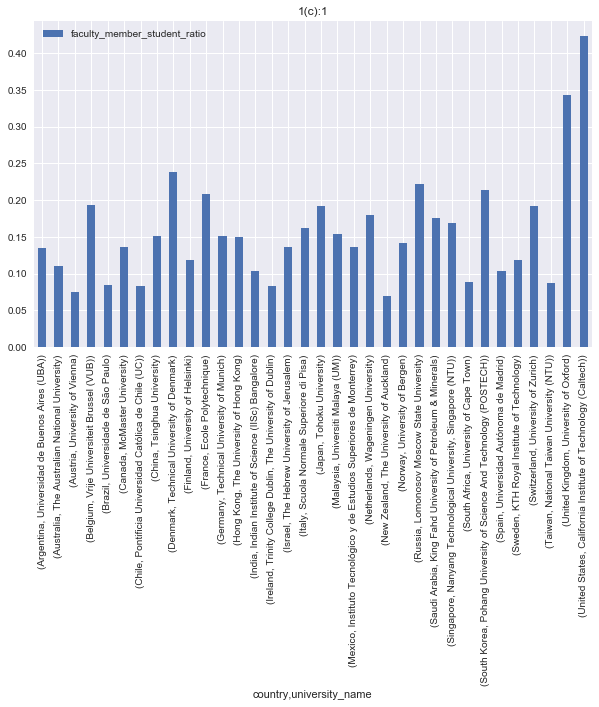

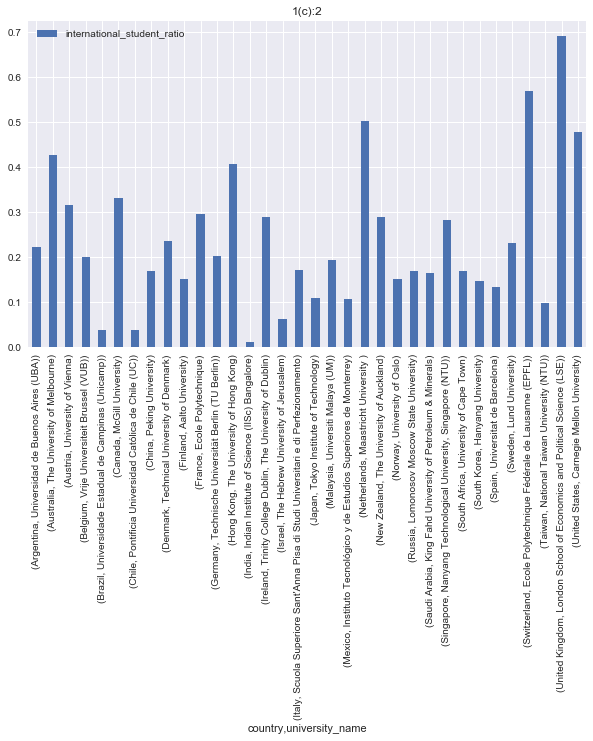

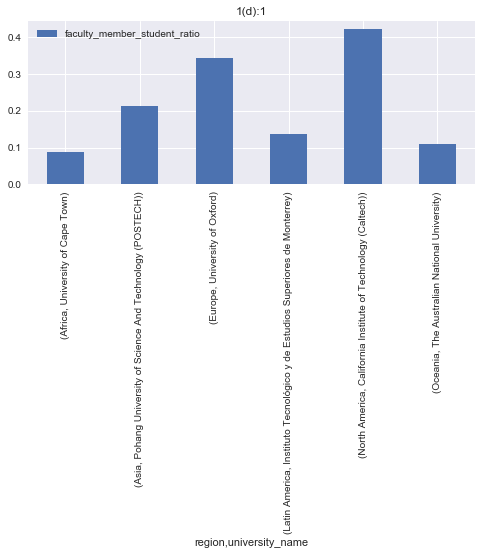

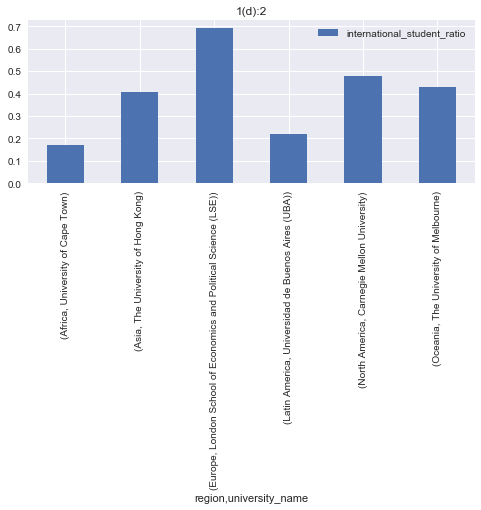

In [15]:
# Aggregating the result as in 1c
plot01_data = qs_country_grouped.sort_values('faculty_member_student_ratio', ascending=False).groupby('country', as_index=False).first()
plot02_data = qs_country_grouped.sort_values('international_student_ratio', ascending=False).groupby('country', as_index=False).first()

# Aggregating the result as in 1d
plot03_data = qs_region_grouped.sort_values('faculty_member_student_ratio', ascending=False).groupby('region', as_index=False).first()
plot04_data = qs_region_grouped.sort_values('international_student_ratio', ascending=False).groupby('region', as_index=False).first()

# Drawing the result 1c as plot01 and plot02
plot01=plot01_data.plot(y='faculty_member_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='1(c):1')
plot02=plot02_data.plot(y='international_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='1(c):2')

# Drawing the result 1d as plot03 and plot04
plot03=plot03_data.plot(y='faculty_member_student_ratio', x=['region','university_name'], kind='bar', grid=True, figsize=(8, 3), title='1(d):1')
plot04=plot04_data.plot(y='international_student_ratio', x=['region','university_name'], kind='bar', grid=True, figsize=(8, 3), title='1(d):2')

#### Obersvation

By Country:
For the faculty members and students ratio we can see that the US and the UK have a clearly higher ratio than other countries, while for the international students ratio the US are slightly below some countries in Europe as The UK or Switzerland. We can also notice a very weak portion of international students in some countries of Latin America as Brazil or Chile but the smallest part remains in India.

By Region:
We observe similar things in regions, North America and Europe are ahead in terms of faculty members and students ratio and as well for the proportion of international students. We also have that the weakest region for both ratio is Africa, this is probably due, in a way, to the fact that there is only one university in the top 200.

# 2.Analysis of Times Higher Education Data
Second is to do data scarping from timeshighereducation.com.<br>
<b> Please skip this part if you want to avoid generating web traffics. </b><br>
<b> Note that you will get the same data as from saved pickle file </b>

In [16]:
# Store the data of the 200 top-ranking universities in timeshighereducation into a dataframe
times_top200 = crawl_timeshighereducation(web_urls[1],200)

In [17]:
times_top200.head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,United Kingdom,0.38,1,11.2,20409,University of Oxford
1,United Kingdom,0.35,2,10.9,18389,University of Cambridge
2,United States,0.27,3,6.5,2209,California Institute of Technology


<b>Writing Data into a file</b>
<br><b>Note: Run this cell to save the times_top200 dataframe into pickle file. Later, we can read the pickle file to avoid generating redundant HTTP requests</b>
<br><b>Please skip this part if you do not want to store the dataframe into a pickle file</b>

In [18]:
times_top200.to_pickle("times_top200_pickle")

### 2a. Best Universities: Student/Staff Ratio
<b> Note that for this attributes, the lower ratio indicates a better university in rank. In QS the ratio is reversed which is staff/student ratio </b>

In [19]:
# find out which universities are the best in terms of ratio student/staff
# display the top 3 in this context
times_top200.sort_values("student_staff_ratio",ascending=True).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
105,United States,0.13,105,3.3,12011,Vanderbilt University
109,Denmark,0.14,109,4.1,30395,University of Copenhagen
12,United States,0.24,13,4.3,15498,Johns Hopkins University


### 2b. Best Universities: International Student Ratio

In [20]:
# find out which universities are the best in terms of ratio international student/total student
# display the top 3 in this context
times_top200.sort_values("percentage_international_students",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
24,United Kingdom,0.71,25,12.2,10065,London School of Economics and Political Science
178,Luxembourg,0.57,179,14.6,4969,University of Luxembourg
37,Switzerland,0.55,38,11.2,9928,École Polytechnique Fédérale de Lausanne


### 2c. Best Universities In terms of Ratio of Student/Staff and Percentage of International Students, aggregated per Country

In [21]:
# Display the best universities in each country based on faculty_member_student_ratio
display(times_top200.sort_values('student_staff_ratio', ascending=True).groupby('country', as_index=False).first())

# Display the best universities in each country based on international_student_ratio
display(times_top200.sort_values('percentage_international_students', ascending=False).groupby('country', as_index=False).first())

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,Australia,0.35,48,19.3,15986,Australian National University
1,Austria,0.26,165,20.8,35375,University of Vienna
2,Belgium,0.10,107,35.9,35909,Ghent University
3,Canada,0.26,42,13.3,30940,McGill University
4,China,0.03,132,8.2,16032,University of Science and Technology of China
5,Denmark,0.14,109,4.1,30395,University of Copenhagen
6,Finland,0.06,90,16.2,22532,University of Helsinki
7,France,0.36,115,5.1,2799,École Polytechnique
8,Germany,0.15,34,15.6,36091,LMU Munich
9,Hong Kong,0.35,119,11.2,9240,City University of Hong Kong


,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,Australia,0.40,32,26.6,42116,University of Melbourne
1,Austria,0.26,165,20.8,35375,University of Vienna
2,Belgium,0.35,175,43.4,25343,Université Libre de Bruxelles
3,Canada,0.29,34,18.1,51889,University of British Columbia
4,China,0.16,27,8.9,42136,Peking University
5,Denmark,0.24,153,6.0,8548,Technical University of Denmark
6,Finland,0.20,190,20.2,12744,Aalto University
7,France,0.36,115,5.1,2799,École Polytechnique
8,Germany,0.23,41,54.4,38689,Technical University of Munich
9,Hong Kong,0.42,40,18.0,18364,University of Hong Kong


### Plot : Bar Charts
Based on results 2c, we draw 2 bar charts

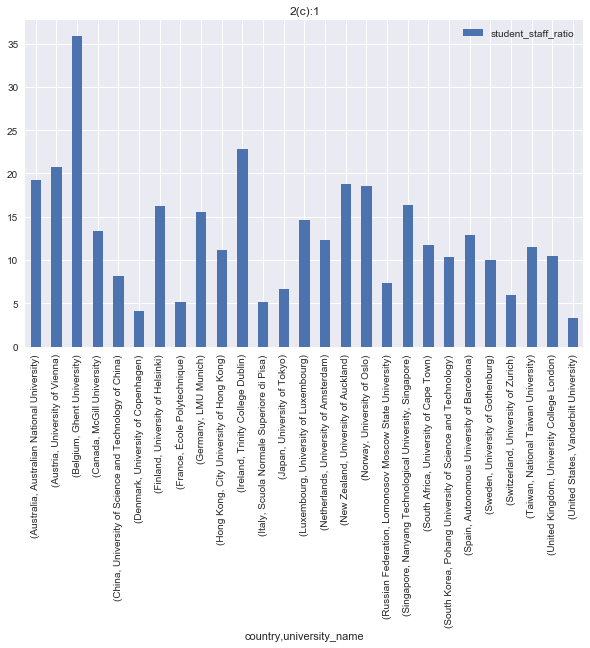

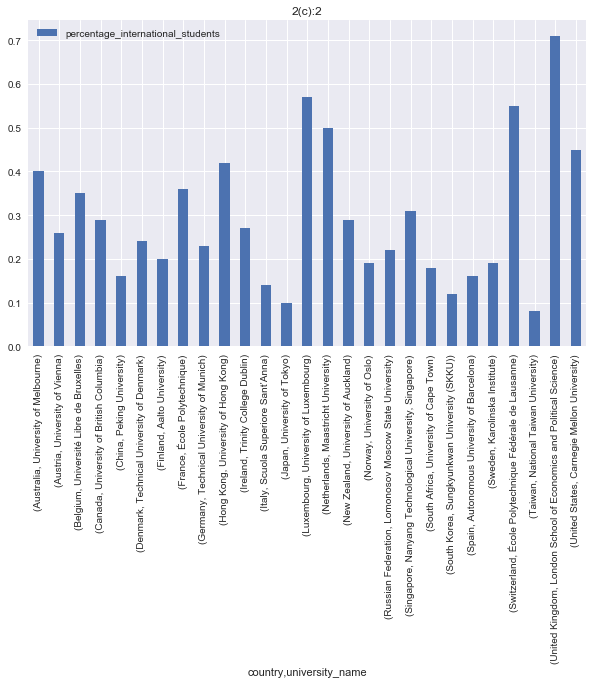

In [22]:
# Aggregating the result as in 2c
plot05_data = times_top200.sort_values('student_staff_ratio', ascending=True).groupby('country', as_index=False).first()
plot06_data = times_top200.sort_values('percentage_international_students', ascending=False).groupby('country', as_index=False).first()

# Drawing the result 2c as plot05 and plot06
plot05=plot05_data.plot(y='student_staff_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='2(c):1')
plot06=plot06_data.plot(y='percentage_international_students', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='2(c):2')

#### Obersvation

For the Times ranking we have a very different ranking in terms of faculty members and students ratio the US are very low compared to other countries and Belgium is way ahead with Ireland. If we had regions for the Times ranking we would clearly have Europe as dominant region for the first ratio.

In terms of international students, the Times and QS rankings are quite similar, Europe has the most important proportion and the UK, Switzerland and Luxembourg form the top 3. It also looks like Asia has the lowest rate of international students as Japan and Taiwan are the countries at the bottom of the chart.

# 3.Merging Dataframe
#### To accurately merge both data from topuniversities (qs) and timehighereducation (times), we divide the merging process into 5 parts as follows:
1. Forming dataframe df1 and df2 with university_name as the index. University_name must not contains parentheses and non-ascii characters.
2. Performing inner join from df1 and df2 based on university_name
3. Doing manual matching for the rest of universities in df1 that fails exact matching in inner join at step 2.
4. Doing manual matching for the rest of universities in df2 that fails exact matching in inner join at step 2.
5. Combining the result from 2,3,4

### 3.1. Forming New Dataframes with university_name as index
To avoid failures when performing inner join, we remove any form of parentheses in both dataframe from qs and times. We descibe the problem as follows:<br><br>
For example, in QS the name of remarkable MIT is <i><b>"Massachusetts Institute of Technology (MIT)"</b></i> meanwhile in times it is <i><b>"Massachusetts Institute of Technology"</b></i>, without abbreviation.
<br>
In addition, in in qs our beloved campus is ranked as <i><b>"Ecole Polytechnique Fédérale de Lausanne (EPFL)"</b></i>. However in times the name is recorded as <i><b>"École Polytechnique Fédérale de Lausanne"</b></i>, with non-ascii character (É) as first letter.
<br><br>
Therefore, to perform inner join with exact matching of university_name, we figure out that we need to remove parentheses and non-ascii characters from university_name. We use function <b>"convert_index"</b> as explained in section functions.

In [23]:
# Forming the dataframe df1, using university_name with its parentheses and non-ascii characters removed and converted
df1 = df_convert_index(qs_top200)

# Adding prefix qs_ to keep track of data from topuniversities
df1 = df1.add_prefix("qs_")

# Forming the dataframe df2, using university_name with its parentheses and non-ascii characters removed and converted
df2 = df_convert_index(times_top200)

# Adding prefix times_ to keep track of data from timeshighereducation
df2 = df2.add_prefix("times_")

display(df1.head(3))
display(df2.head(3))

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students
university_name,,,,,,,
Massachusetts Institute of Technology,United States,1,North America,2982,1679,3717,11067
Stanford University,United States,2,North America,4285,2042,3611,15878
Harvard University,United States,3,North America,4350,1311,5266,22429


,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,
University of Oxford,United Kingdom,0.38,1,11.2,20409
University of Cambridge,United Kingdom,0.35,2,10.9,18389
California Institute of Technology,United States,0.27,3,6.5,2209


### 3.2: Inner Join based on university_name (exact matching)
We perform inner join and assign the result as df_merged_exact_match.
In addition, we store the rest of universities record in qs as df1_rest and the rest of universities record in times as df2_rest

In [24]:
# find matching index in df2 from df1
df1_matching_idx      = (df1.index).isin(df2.index)

# forming with inner join, exact match
df_merged_exact_match = pd.concat([df1[df1_matching_idx], df2], axis=1, join='inner')

# display the first 10 top entry of the join result
display(df_merged_exact_match.head(10))


# form the rest of record in qs as df1_rest for step 3.3 & 3.4
df1_rest              = df1[~df1_matching_idx]

# find matching index in df1 from df2
df2_matching_idx      = (df2.index).isin(df1.index)

# form the rest of record in times as df2_rest for step 3.3 & 3.4
df2_rest              = df2[~df2_matching_idx]

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
University of Oxford,United Kingdom,6,Europe,6750,2964,7353,19720,United Kingdom,0.38,1,11.2,20409
University of Cambridge,United Kingdom,5,Europe,5490,2278,6699,18770,United Kingdom,0.35,2,10.9,18389
California Institute of Technology,United States,4,North America,953,350,647,2255,United States,0.27,3,6.5,2209
Stanford University,United States,2,North America,4285,2042,3611,15878,United States,0.22,3,7.5,15845
Massachusetts Institute of Technology,United States,1,North America,2982,1679,3717,11067,United States,0.34,5,8.7,11177
Harvard University,United States,3,North America,4350,1311,5266,22429,United States,0.26,6,8.9,20326
Princeton University,United States,13,North America,1007,246,1793,8069,United States,0.24,7,8.3,7955
Imperial College London,United Kingdom,8,Europe,3930,2071,8746,16090,United Kingdom,0.55,8,11.4,15857
University of Chicago,United States,9,North America,2449,635,3379,13557,United States,0.25,9,6.2,13525


### 3.3: Manual Matching for the rest of df1
We observed some exceptions that we cannot avoid to solve manually. For example, in qs <b><i>Technische Universität Berlin</i></b> differ in name with <b><i>Technical University of Berlin</i></b> in times but they are actually the same university. Thus we perform manual checking through if else statement (although it is a bit long here). But we confident that it is the best approaches we have for this task.

<br>
Overall, we use the first three words of university_name as keyword, and we try to find "similiar" patern in df2_rest. 
* Exception for university_name less than < 3, we only use the first word.
* Exception for keyword starts with "University of", we use the rest of words in university_name as keyword starting from the third.
* Exception for keyword starts with "The", we use the rest of words in university_name as keyword starting from the second.

In [25]:
# a list to store the matching index of df1
university_list = []

# Loop through df1_rest
for index, row in df1_rest.iterrows():  
    
    # Handle the exception, some universities have less than 3 words in name
    try:       
        # Pick the first three words of university_name as keyword
        keyword = " ".join(index.split()[:3])
        
        # Remove thrilling comma (if any)
        if(keyword.endswith(",")):
            keyword = keyword[:-1]
            
    # Exception, pick only the first word in university_name        
    except IndexError:
        keyword = index.split()[0]
    
    #================ Manual Matching Starts ======================#
    if(keyword.startswith("The")):
        keyword = " ".join(index.split()[1:])
    elif(keyword.startswith("University of")):
        keyword = " ".join(index.split()[2:])
    elif(keyword.startswith("UCL")):
        keyword = "University College London"
    elif(keyword.startswith("King's College")):
        keyword = "Kings College"
    elif(keyword.startswith("KAIST")):
        keyword = "Korea Advanced Institute"
    elif(keyword.startswith("Ludwig")):
        keyword = "LMU"
    elif(keyword.endswith("Heidelberg")):
        keyword = "Heidelberg"
    elif(keyword.startswith("KIT")):
        keyword = "Karlsruhe"
    elif(keyword.startswith("Humboldt")):
        keyword = "Humboldt"
    elif(keyword.endswith("Montreal")):
        keyword = "Montreal"
    elif(keyword.startswith("Universite Pierre")):
        keyword = "Pierre"
    elif(keyword.startswith("Technische")):
        keyword = "Technical University of Berlin"
    elif(keyword.endswith("Catholique")):
        keyword = "Catholique"
    elif(keyword.startswith("ETH")):
        keyword = "ETH Zurich"
    elif(keyword.startswith("Freie")):
        keyword = "Free University"
    elif(keyword.startswith("Universite catholique")):
        keyword = "Louvain"
    elif(keyword.startswith("Eberhard Karls")):
        keyword = "Tubingen"
    elif(keyword.startswith("Albert-Ludwigs-Universitaet")):
        keyword = "Freiburg"
    elif(keyword.startswith("Scuola Superiore")):
        keyword = "Scuola Superiore"
    elif(keyword.startswith("Universitat Autonoma")):
        keyword = "Autonomous University"    
    #================ Manual Matching Ends ======================#
    
    # Check for matching entry in df2_rest based on given keyword
    matched_times_data = df2_rest.filter(like=keyword, axis=0)
    
    # if matching entry is found in df2_rest
    if(matched_times_data.empty is False):
        # obtain the record from df1_rest
        matched_qs_data = df1_rest.loc[[index]]
        
        # form one-row dataframe, keep university_name of both qs and times to recheck that we pick the exact same university
        formed_qs_times = pd.concat([matched_qs_data.reset_index(), matched_times_data.reset_index()], axis=1)
        
        # set university_name as index
        formed_qs_times = formed_qs_times.set_index(['university_name'])
        
        # store the result of manual matching to list
        university_list.append(formed_qs_times.iloc[[0]])
    
        # remove the matching record from df2_rest 
        df2_rest = df2_rest.drop(matched_times_data.index)

# From list of matching universities, store it as panda DataFrame        
qs_times_matched_1 = pd.concat(university_list)

# Display the result of step 3.3
qs_times_matched_1

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
"(UCL, University College London)",United Kingdom,7.0,Europe,6345.0,2554.0,14854.0,31080.0,United Kingdom,0.49,16,10.5,30304
"(ETH Zurich - Swiss Federal Institute of Technology, ETH Zurich Swiss Federal Institute of Technology Zurich)",Switzerland,10.0,Europe,2477.0,1886.0,7563.0,19815.0,Switzerland,0.38,10,14.6,19233
"(The Australian National University, Australian National University)",Australia,20.0,Oceania,1600.0,927.0,5551.0,14442.0,Australia,0.35,48,19.3,15986
"(King's College London, Kings College London)",United Kingdom,23.0,Europe,3650.0,1513.0,9451.0,23780.0,United Kingdom,0.41,36,12.0,23207
"(The University of Edinburgh, University of Edinburgh)",United Kingdom,23.0,Europe,4075.0,1553.0,10551.0,28040.0,United Kingdom,0.40,27,12.5,26759
"(The University of Hong Kong, University of Hong Kong)",Hong Kong,26.0,Asia,3012.0,2085.0,8230.0,20214.0,Hong Kong,0.42,40,18.0,18364
"(The University of Tokyo, University of Tokyo)",Japan,28.0,Asia,4514.0,254.0,2639.0,27279.0,Japan,0.10,46,6.7,26000
"(The Hong Kong University of Science and Technology, Hong Kong University of Science and Technology)",Hong Kong,30.0,Asia,1150.0,835.0,2921.0,10375.0,Hong Kong,0.31,44,23.1,10214
"(The University of Manchester, University of Manchester)",United Kingdom,34.0,Europe,4910.0,1653.0,13514.0,36670.0,United Kingdom,0.38,54,14.6,35318


#### How many matching universities?

In [26]:
# Find out how many matching university names obtained from step 3.3
qs_times_matched_1.shape[0]

40

### 3.4: Manual Matching for the rest of df2
Same as 3.3 but now we do the manual matching by iterating through the rest of df2 from step 3.2 & 3.3

<br>
Overall, we use the first three words of university_name as keyword, and we try to find "similiar" patern in df1_rest. 
* Exception for university_name less than < 3, we only use the first word.
* Exception for keyword starts with "University of", we use the rest of words in university_name as keyword starting from the third.
* Exception for keyword starts with "The", we use the rest of words in university_name as keyword starting from the second.
* <b> We observe that the only remaining university record presents in both qs and times is University of North Carolina at Chapel Hill </b>

In [27]:
# a list to store the matching index of df2
university_list = []

# Loop through df2_rest
for index, row in df2_rest.iterrows():  
    
    # Handle the exception, some universities have less than 3 words in name
    try:       
        # Pick the first three words of university_name as keyword
        keyword = " ".join(index.split()[:3])
        
        # Remove thrilling comma (if any)
        if(keyword.endswith(",")):
            keyword = keyword[:-1]
            
    # Exception, pick only the first word in university_name        
    except IndexError:
        keyword = index.split()[0]
    
    #================ Manual Matching Starts ======================#
    if(keyword.startswith("The")):
        keyword = " ".join(index.split()[1:])
    elif(keyword.startswith("University of North")):
        keyword = "North Carolina"
    elif(keyword.startswith("University of")):
        keyword = " ".join(index.split()[2:])
    #================ Manual Matching Ends ======================#
    
    # Check for matching entry in df1_rest based on given keyword
    matched_qs_data = df1_rest.filter(like=keyword, axis=0)
    
    # if matching entry is found in df1_rest
    if(matched_qs_data.empty is False):
        
        # obtain the record from df2_rest
        matched_times_data = df2_rest.loc[[index]]
        
        # form one-row dataframe, keep university_name of both qs and times to recheck that we pick the exact same university
        formed_qs_times    = pd.concat([matched_times_data.reset_index(),matched_qs_data.reset_index()],axis=1)
        
        # set university_name as index
        formed_qs_times    = formed_qs_times.set_index(['university_name'])
        
        # store the result of manual matching to list
        university_list.append(formed_qs_times.iloc[[0]])

# From list of matching universities, store it as panda DataFrame        
qs_times_matched_2 = pd.concat(university_list)

# Display the result of step 3.4
qs_times_matched_2

,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students
university_name,,,,,,,,,,,,
"(University of North Carolina at Chapel Hill, University of North Carolina, Chapel Hill)",United States,0.08,56,9.7,34684,United States,80,North America,4083,524,1934,25373


#### How many matching universities?

In [28]:
# Find out how many matching university names obtained from step 3.3
qs_times_matched_2.shape[0]

1

## 3.5: Finally Merging Universities Data that Present in Both QS and Times
Now we merge dataframe obtained from step 3.2, 3.3, & 3.4.<br>
Note that we discard all records that not available in <i>both</i> dataframe.

In [29]:
# Merging final dataframe
dataframes        = [df_merged_exact_match, qs_times_matched_1, qs_times_matched_2]
combined_qs_times = pd.concat(dataframes)

# Display the data
display(combined_qs_times)

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
University of Oxford,United Kingdom,6.0,Europe,6750.0,2964.0,7353.0,19720.0,United Kingdom,0.38,1,11.2,20409
University of Cambridge,United Kingdom,5.0,Europe,5490.0,2278.0,6699.0,18770.0,United Kingdom,0.35,2,10.9,18389
California Institute of Technology,United States,4.0,North America,953.0,350.0,647.0,2255.0,United States,0.27,3,6.5,2209
Stanford University,United States,2.0,North America,4285.0,2042.0,3611.0,15878.0,United States,0.22,3,7.5,15845
Massachusetts Institute of Technology,United States,1.0,North America,2982.0,1679.0,3717.0,11067.0,United States,0.34,5,8.7,11177
Harvard University,United States,3.0,North America,4350.0,1311.0,5266.0,22429.0,United States,0.26,6,8.9,20326
Princeton University,United States,13.0,North America,1007.0,246.0,1793.0,8069.0,United States,0.24,7,8.3,7955
Imperial College London,United Kingdom,8.0,Europe,3930.0,2071.0,8746.0,16090.0,United Kingdom,0.55,8,11.4,15857
University of Chicago,United States,9.0,North America,2449.0,635.0,3379.0,13557.0,United States,0.25,9,6.2,13525


# 4. Exploratory Data Analysis

#### Adding Columns of QS Percentage International Faculties and QS Percentage of International Students

In [30]:
# QS Percentage of international faculty members
combined_qs_times['qs_percentage_international_faculties'] = combined_qs_times.qs_total_international_faculty_members/combined_qs_times.qs_total_faculty_members

# QS Percentage of international students
combined_qs_times['qs_percentage_international_students'] = combined_qs_times.qs_total_international_students/combined_qs_times.qs_total_students


### Relation between two variables
We will use the following table to reveal some phenomenon

In [31]:
combined_qs_times.corr()

,qs_rank,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students,qs_percentage_international_faculties,qs_percentage_international_students
qs_rank,1.000000,-0.360995,-0.508268,-0.252967,-0.017127,-0.304700,0.690482,0.256399,-0.029607,-0.356288,-0.317271
qs_total_faculty_members,-0.360995,1.000000,0.651313,0.424276,0.597126,-0.127924,-0.349725,-0.099350,0.576543,-0.092944,-0.081224
qs_total_international_faculty_members,-0.508268,0.651313,1.000000,0.586207,0.298613,0.323515,-0.349446,-0.064337,0.268778,0.601416,0.383333
qs_total_international_students,-0.252967,0.424276,0.586207,1.000000,0.633347,0.413787,-0.241208,0.232315,0.556707,0.326568,0.529934
qs_total_students,-0.017127,0.597126,0.298613,0.633347,1.000000,-0.275492,-0.134993,0.318147,0.947301,-0.188823,-0.204539
times_percentage_international_students,-0.304700,-0.127924,0.323515,0.413787,-0.275492,1.000000,-0.196366,-0.061179,-0.300749,0.639827,0.954917
times_rank,0.690482,-0.349725,-0.349446,-0.241208,-0.134993,-0.196366,1.000000,0.054124,-0.154041,-0.124555,-0.219282
times_student_staff_ratio,0.256399,-0.099350,-0.064337,0.232315,0.318147,-0.061179,0.054124,1.000000,0.299797,0.010097,-0.046337
times_total_students,-0.029607,0.576543,0.268778,0.556707,0.947301,-0.300749,-0.154041,0.299797,1.000000,-0.201743,-0.236330
qs_percentage_international_faculties,-0.356288,-0.092944,0.601416,0.326568,-0.188823,0.639827,-0.124555,0.010097,-0.201743,1.000000,0.658636


#### Does the university with higher proportion of international students also have higher proportion of international faculties?
In the result above, we could see the coefficient coefficient of % of international students and % of international faculties is 0.642269, which tells us that a university with more percentage of international students tends to have more percentage of international faculties (Like EPFL). 

However, we could also see some outliers in the plot. For example, there're some schools with lower proportion of international students but with higher proportion of international faculties, and it turns out to be the two universities in Switzerland: University of Zurich and University of Bern

University with fewer than 20% of international students but with more than 50% of international faculties
University of Bern
University of Zurich


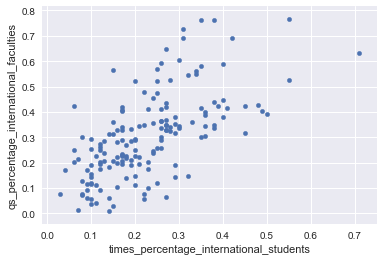

In [32]:
combined_qs_times.plot.scatter(x='times_percentage_international_students', y='qs_percentage_international_faculties');
print('University with fewer than 20% of international students but with more than 50% of international faculties')
for university in combined_qs_times.index[(combined_qs_times.qs_percentage_international_faculties > 0.5) & \
                                          (combined_qs_times.times_percentage_international_students <= 0.2)]:
    print(university)

#### Does higher # of international faculties help the ranking?
We could see generally this is true, and now we observer the outlier (the one with very high ranking but with few number of international faculties). We could find generally there are two kinds of groups. The first group is the universities in Asia, and the other group is the universities in USA.

California Institute of Technology
Princeton University
Duke University
Carnegie Mellon University
Kyoto University
Seoul National University
('The University of Tokyo', 'University of Tokyo')
('KAIST - Korea Advanced Institute of Science & Technology', 'Korea Advanced Institute of Science and Technology')


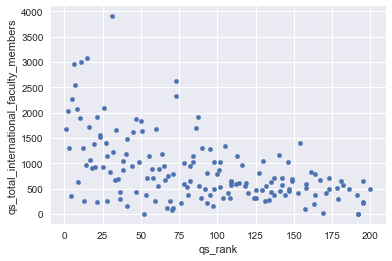

In [33]:
combined_qs_times.plot.scatter(x='qs_rank', y='qs_total_international_faculty_members');
for university in combined_qs_times.index[(combined_qs_times.qs_rank < 50) & \
                                          (combined_qs_times.qs_total_international_faculty_members < 500)]:
    print(university)

#### Does the # of students move with # of faculties?
The correlation between these two attributes is 0.59, and it reveals a natural result: If there are more students, we need more faculties. And there are some outliers with roughly 60000 students and fewer than 3000 faculties.

University with fewer than 4000 faculties and more than 50000 students:
University of Washington
Monash University
Texas A&M University


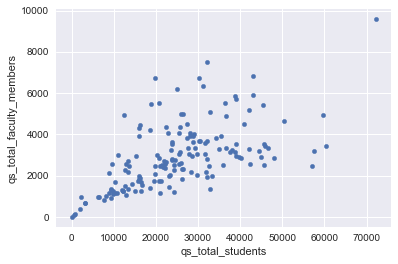

In [34]:
combined_qs_times.plot.scatter(x='qs_total_students', y='qs_total_faculty_members');
print('University with fewer than 4000 faculties and more than 50000 students:')
for university in combined_qs_times.index[(combined_qs_times.qs_total_students > 50000) & (combined_qs_times.qs_total_faculty_members < 4000)]:
    print(university)

#### How does QS ranking and Times ranking differ?
We could see an interesting phenomenon: There's no big difference within the top 30 universities in QS ranking and Times ranking (we could see an obvious line there), and after 30, the ranking starts to differ a lot.

In the following we show the universities which are top 100 in QS but more than 150 in Times, and we can see the universities are mostly in Asia (Only KTH is in Europe). On the other hand, the universities which are top 100 in Times but more than 150 in QS are in Europe and USA.

University which is top 100 in QS but more than 150 in Times
KTH Royal Institute of Technology
Zhejiang University
Shanghai Jiao Tong University
Lomonosov Moscow State University
National Taiwan University
('The University of Auckland', 'University of Auckland')
('The Hong Kong Polytechnic University', 'Hong Kong Polytechnic University')

University which is top 100 in Times but more than 150 in QS
University of Minnesota
Dartmouth College
University of California, Irvine
('Eberhard Karls Universitat Tubingen', 'University of Tubingen')
('Albert-Ludwigs-Universitaet Freiburg', 'University of Freiburg')


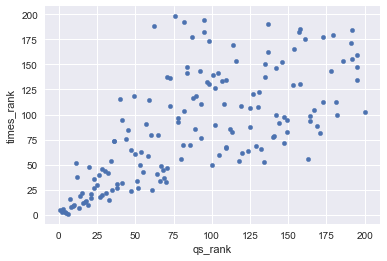

In [35]:
combined_qs_times.plot.scatter(x='qs_rank', y='times_rank');

print('University which is top 100 in QS but more than 150 in Times')
for university in combined_qs_times.index[(combined_qs_times.qs_rank < 100) & (combined_qs_times.times_rank > 150)]:
    print(university)
print()
print('University which is top 100 in Times but more than 150 in QS')
for university in combined_qs_times.index[(combined_qs_times.times_rank < 100) & (combined_qs_times.qs_rank > 150)]:
    print(university)

#### Distribution of QS and Times rankings per region and country

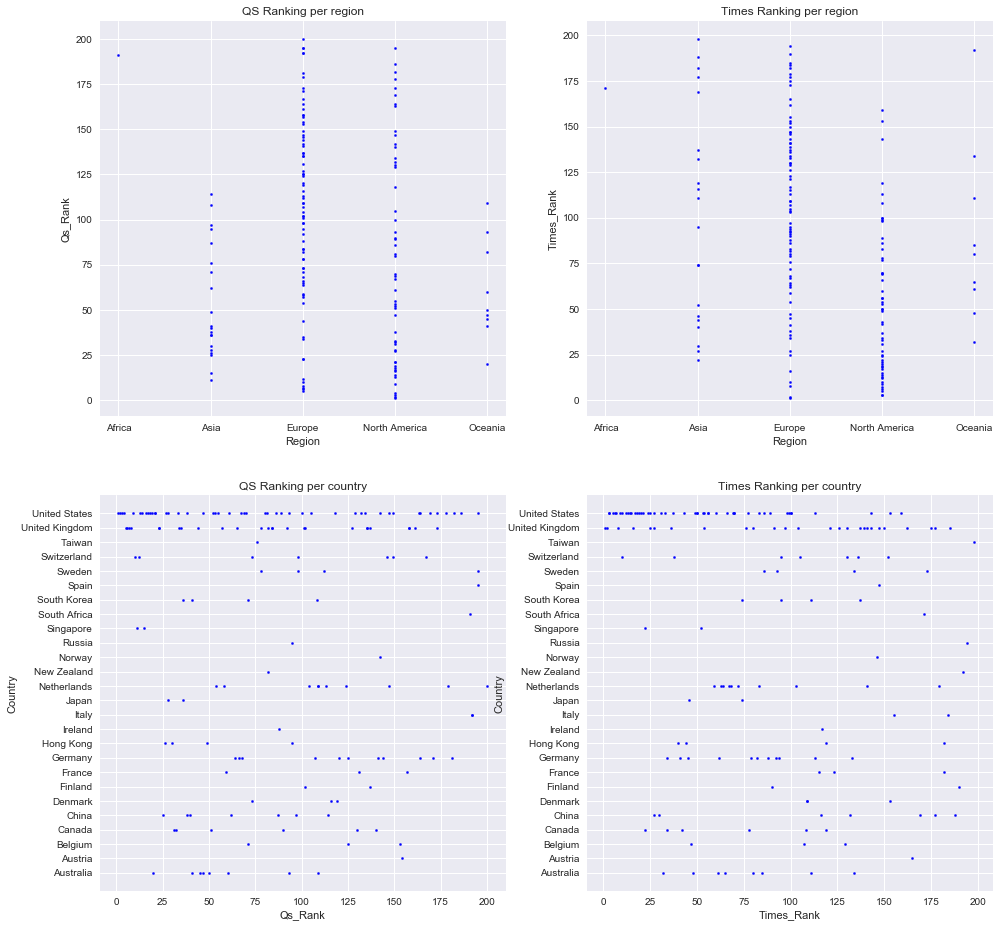

In [53]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(2, 2, 1)
Xuniques, X = np.unique(combined_qs_times['qs_region'], return_inverse=True)
ax.scatter(X, combined_qs_times['qs_rank'], s=5, c='b')
ax.set(xticks=range(len(Xuniques)), xticklabels=Xuniques) 
ax.set_title('QS Ranking per region')
ax.set_xlabel('Region')
ax.set_ylabel('Qs_Rank')
bx = fig.add_subplot(2, 2, 2)
bx.scatter(X, combined_qs_times['times_rank'], s=5, c='b')
bx.set(xticks=range(len(Xuniques)), xticklabels=Xuniques) 
bx.set_title('Times Ranking per region')
bx.set_xlabel('Region')
bx.set_ylabel('Times_Rank')
cx = fig.add_subplot(2, 2, 3)
Xuniques, X = np.unique(combined_qs_times['qs_country'], return_inverse=True)
cx.scatter(combined_qs_times['qs_rank'],X, s=5, c='b')
cx.set(yticks=range(len(Xuniques)), yticklabels=Xuniques) 
cx.set_title('QS Ranking per country')
cx.set_ylabel('Country')
cx.set_xlabel('Qs_Rank')
dx = fig.add_subplot(2, 2, 4)
dx.scatter(combined_qs_times['times_rank'],X, s=5, c='b')
dx.set(yticks=range(len(Xuniques)), yticklabels=Xuniques) 
dx.set_title('Times Ranking per country')
dx.set_ylabel('Country')
dx.set_xlabel('Times_Rank')
plt.show()

Top universities for QS are mostly north american while it is Europe which has the top-notch universities for Times. We can also see that Europe has the most important number of universities in the top 200 for both rankings. Also for Asia and Oceania we have that QS ranking is less sparse than Times ranking, i. e. they are better ranked in QS than in Times. 

By looking more in detail we can clearly see that the most represented countries for North America and Europe are the US and the UK respectively. These two countries also have the top 10 universities for both rankings.
One reason to the differences between the two rankings might also be that Times takes the age of the university as a more important parameter than QS does.

#### Does Times give worse ranking to universities in Asia?
This question is naturally asked based on the observation above. We use rank_qs - rank_times to observe the result and we can see that only one university gets higher rank in Times: Peking University

Asia University with higher ranking in Times
Peking University


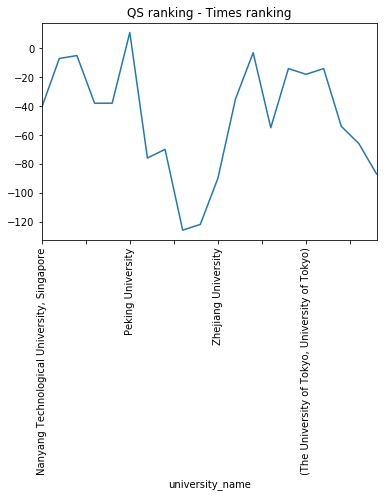

In [18]:
(combined_qs_times.qs_rank[combined_qs_times.qs_region == 'Asia'] - combined_qs_times.times_rank[combined_qs_times.qs_region == 'Asia']).plot(x = 'QS ranking',\
                                                                                                           title = 'QS ranking - Times ranking', rot = 90)

print('Asia University with higher ranking in Times')
for university in combined_qs_times.index[(combined_qs_times.times_rank < combined_qs_times.qs_rank) & (combined_qs_times.qs_region == 'Asia')]:
    print(university)

# 5. Best university taking in consideration both rankings.
In this question, we use harmonic mean of two rankings as the final ranking:
$$ \overline{x} = \frac{2x_1x_2}{(x_1 + x_2)} $$
the reason to use harmonic mean is that we want put more emphasis on better ranking. The property of harmonic mean is that the mean would be more close to the one with small number (i.e. higher ranking)

We don't use regression to combine the ranking, and the reason is that we don't have too many features in our dataset (at least we know both rankings are based on lots of other attributes such as Citations per Faculty, Academic Reputation, Employer Reputation ... etc), and hence use regression to calculate the ranking would cause underfitting.

In [22]:
harmonic_mean = (2 * combined_qs_times.qs_rank * combined_qs_times.times_rank)/(combined_qs_times.qs_rank + combined_qs_times.times_rank)
harmonic_mean = harmonic_mean.sort_values()
final_rank = pd.Series([i+1 for i, score in enumerate(harmonic_mean)], index = harmonic_mean.index)
pd.DataFrame(final_rank, columns = ['ranking']).head(20)


,ranking
university_name,
Massachusetts Institute of Technology,1
University of Oxford,2
Stanford University,3
University of Cambridge,4
California Institute of Technology,5
Harvard University,6
Imperial College London,7
University of Chicago,8
Princeton University,9
